In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os, shutil
import numpy as np
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import accuracy_score
import torchvision.models as models
from sklearn.decomposition import PCA

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_transform = transforms.Compose([
     transforms.Resize([224,224]),
#     transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#     transforms.RandomRotation(degrees=15),#随机旋转15°
#     transforms.RandomHorizontalFlip(),#随机水平翻转图片
    #transforms.CenterCrop(80),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [4]:
all_dataset= torchvision.datasets.ImageFolder(root='dataset',transform=data_transform)

In [5]:
train_size = int(len(all_dataset) * 0.7)
test_size = len(all_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])

In [6]:
class_names = all_dataset.classes
print(class_names)

['hunzhuo', 'tuoli']


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True,)

In [8]:
train_data, train_labels = next(iter(train_loader))
print(u'train_data个数{}'.format(len(train_data)))
print(u'train_labels个数{}'.format(len(train_labels)))
print(train_data.shape)

train_data个数20
train_labels个数20
torch.Size([20, 3, 224, 224])


In [9]:
import timm
swin= timm.create_model('swin_base_patch4_window7_224')

/opt/conda/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
pretrained_dict = torch.load('swin_base_patch4_window7_224_22kto1k.pth')
swin.load_state_dict(pretrained_dict['model'])

<All keys matched successfully>

In [11]:
print(swin)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(

In [12]:
swin.head.out_features = 2

In [13]:
# print(swin)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(

In [15]:
model = swin

In [16]:
criterion=nn.CrossEntropyLoss()
params = filter(lambda p: p.requires_grad, model.parameters())
opti = torch.optim.Adam(params, lr=1e-5)

In [20]:
EPOCH=10

In [18]:
model = model.to(device)

In [21]:
if __name__ =='__main__':
    Accuracy_list = []
    Loss_list = []
 
    for epoch in range(EPOCH):
        sum_loss = 0.0
        correct1 = 0
 
        total1 = 0
        for i,(images,labels) in enumerate(train_loader):
            num_images=images.size(0)
 
            images=Variable(images.to(device))
            labels=Variable(labels.to(device))
 
            out=model(images)
            _, predicted = torch.max(out.data, 1)
            total1 += labels.size(0)
 
            correct1 += (predicted == labels).sum().item()
 
 
            loss=criterion(out,labels)
            print(loss)
            opti.zero_grad()
            loss.backward()
            opti.step()
 
            
            sum_loss += loss.item()
            if i % 2 == 0:
                print('[%d, %d] loss: %.03f'
                      % (epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0.0
        Accuracy_list.append(100.0*correct1 / total1)
        print('accurary={}'.format(100.0*correct1 / total1))
        Loss_list.append(loss.item())

tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward0>)
[1, 1] loss: 0.000
tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0278, device='cuda:0', grad_fn=<NllLossBackward0>)
[1, 3] loss: 0.000
tensor(0.1093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward0>)
[1, 5] loss: 0.001
tensor(0.0169, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0377, device='cuda:0', grad_fn=<NllLossBackward0>)
[1, 7] loss: 0.001
tensor(0.0628, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward0>)
[1, 9] loss: 0.001
tensor(0.0071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0253, device='cuda:0', grad_fn=<NllLossBackward0>)
[1, 11] loss: 0.000
tensor(0.0138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1037, device='cuda:0', grad_fn=<NllLossBackward0>)
[1, 13] loss: 0.001
tensor(0.0098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0146, device='cu

In [33]:
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import type_of_target

from sklearn.metrics import precision_score, recall_score, f1_score
def computeTestSetAccuracy(model, loss_function):
#     device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
    test_acc = 0.0
    test_loss = 0.0
    precision =0.0
    recall = 0.0
    f1score = 0.0
    predlabel_list =[]
    pred_list = []
    with torch.no_grad():
        model.eval()
 
        for j, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            a = labels.tolist()
            
            for x in a:
#                 print(type(x))
                predlabel_list.append(x)
            
            outputs = model(inputs)
 
            loss = loss_function(outputs, labels)
 
            test_loss += loss.item() * inputs.size(0)
 
            ret, predictions = torch.max(outputs.data, 1)
    
            b = predictions.tolist()
            for z in b:
                pred_list.append(z)
                
            correct_counts = predictions.eq(labels.data.view_as(predictions))
 
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
            test_acc += acc.item() * inputs.size(0)
 
            print("Test Batch Number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(
                j, loss.item(), acc.item()
            ))
#             for j in range(inputs.size()[0]):
#                 print("model {} pred label:{}, true label:{}".format(len(predictions), class_names[predictions[j]], class_names[labels[j]]))
#                 if predictions[j] != labels[j]:
#                     img = inputs[j].cpu().numpy()
#                     img = img*0.5+0.5
#                     img = img*255
#                     img = img.transpose([1,2,0])
#                     img =img.astype(np.uint8)
#                     plt.imshow(img)
#                     plt.show()
#     print(predlabel_list)      
    test_data_size = len(test_dataset)
    avg_test_loss = test_loss/test_data_size
    avg_test_acc = test_acc/test_data_size
    p = precision_score(predlabel_list, pred_list)  
    r = recall_score(predlabel_list, pred_list)  
    f1 = f1_score(predlabel_list, pred_list) 
    print('precision:'+str(p))
    print('recall:'+str(r))
    print('f1-score:'+str(f1)) 
    print("Test accuracy : " + str(avg_test_acc))
#     class_report = classification_report(predlabel_list,pred_list,target_names=['class 0','class 1'])
#     print(class_report)


In [34]:
computeTestSetAccuracy(model, criterion)

Test Batch Number: 000, Test: Loss: 1.2819, Accuracy: 0.8000
Test Batch Number: 001, Test: Loss: 0.0020, Accuracy: 1.0000
Test Batch Number: 002, Test: Loss: 0.1784, Accuracy: 0.9000
Test Batch Number: 003, Test: Loss: 0.0023, Accuracy: 1.0000
Test Batch Number: 004, Test: Loss: 2.2441, Accuracy: 0.6000
Test Batch Number: 005, Test: Loss: 0.7837, Accuracy: 0.9000
Test Batch Number: 006, Test: Loss: 0.0018, Accuracy: 1.0000
Test Batch Number: 007, Test: Loss: 0.0079, Accuracy: 1.0000
Test Batch Number: 008, Test: Loss: 0.5400, Accuracy: 0.9000
Test Batch Number: 009, Test: Loss: 0.8696, Accuracy: 0.8000
Test Batch Number: 010, Test: Loss: 0.4070, Accuracy: 0.9000
Test Batch Number: 011, Test: Loss: 1.5550, Accuracy: 0.7000
Test Batch Number: 012, Test: Loss: 0.0006, Accuracy: 1.0000
Test Batch Number: 013, Test: Loss: 1.3247, Accuracy: 0.7500
precision:0.9230769230769231
recall:0.8450704225352113
f1-score:0.8823529411764706
Test accuracy : 0.8805970104772654


In [44]:
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit
import cv2

In [39]:
# !pip install grad_cam

In [40]:
model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(

In [41]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [42]:
target_layers = [model.layers[-2].blocks[-1].norm2]

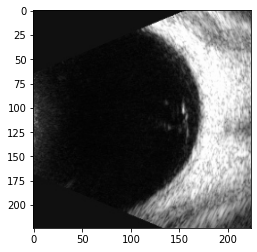

In [46]:
image_path = 'dataset/hunzhuo/hunzhuo0.jpg'
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])
# input_tensor=[input_tensor,input_tensor]
plt.imshow(rgb_img)
plt.show()

In [47]:
cam = GradCAM(model=model, target_layers=target_layers,use_cuda=True, reshape_transform=reshape_transform)

In [48]:
cam.batch_size = 32

In [49]:
grayscale_cam = cam(input_tensor=input_tensor,
                        targets=None,
                        eigen_smooth=False,
                        aug_smooth=False)

In [50]:
grayscale_cam = grayscale_cam[0, :]

In [51]:
cam_image = show_cam_on_image(rgb_img, grayscale_cam)

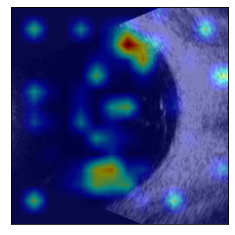

In [53]:
b,g,r = cv2.split(cam_image)			#分别提取B、G、R通道
img_new1 = cv2.merge([r,g,b])
plt.imshow(img_new1)
plt.xticks([]), plt.yticks([]) 
plt.savefig('hunzhuo Swin_transformer')
plt.show()